In [1]:
import sys
import os
sys.path.append(os.path.join(os.path.abspath(''), '../'))

from collections import defaultdict
from evaluation.evaluation_harness import OnlineEvaluator, include_coldstart, include_no_interactions, include_some_interactions, include_all, score_time_spent, score_constant
from statistical_test import estimate_probability_each_model_is_best
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append(os.path.join(os.path.abspath(''), '../backend'))
from backend.blueprints.recommendation import model_wrappers

%load_ext autoreload
%autoreload 2

In [2]:
evaluator = OnlineEvaluator(include_all, score_constant)

In [3]:
current_models = []
for model_wrapper in model_wrappers:
    model_wrapper.model = model_wrapper.definition()
    model_wrapper.model.load(model_wrapper.model_save_file_name, load_published_model=True)
    current_models.append((model_wrapper.model.name(), model_wrapper.model_save_file_name))
evaluation_names = {'evaluation_test_random_model': 'random_model', 'evaluation_test_popularity_model': 'popularity_model', 'evaluation_test_common_neighbors_constant_scoring': 'common_neighbors_constant_scoring', 'evaluation_test_common_neighbors': 'common_neighbors_gaussian_scoring', 'evaluation_test_common_neighbors_percentile_scoring': 'common_neighbors_percentile_scoring', 'evaluation_test_cf_low_weight_decay_increased_lr_best_model_bugfix': 'collborative_filter', 'evaluation_test_gcf_low_weight_decay_increased_lr_best_model_bugfix': 'non_linear_collaborative_filter', 'evaluation_test_mlp_low_weight_decay_increased_lr_best_model_bugfix': 'multilayer_perceptron', 'evaluation_test_ncf_low_weight_decay_increased_lr_best_model_bugfix': 'neural_collaborative_filter', 'evaluation_test_cf_embed_all_except_tags_genres_best_model_bugfix_clip_embeddings': 'collborative_filter_with_game_embeddings', 'evaluation_test_gcf_embed_all_except_tags_genres_best_model_bugfix_clip_embeddings': 'non_linear_collaborative_filter_with_game_embeddings', 'evaluation_test_mlp_embed_all_except_tags_genres_best_model_bugfix_clip_embeddings': 'multilayer_perceptron_with_game_embeddings', 'evaluation_test_ncf_embed_all_except_tags_genres_best_model_bugfix_clip_embeddings': 'neural_collaborative_filter_with_game_embeddings'}

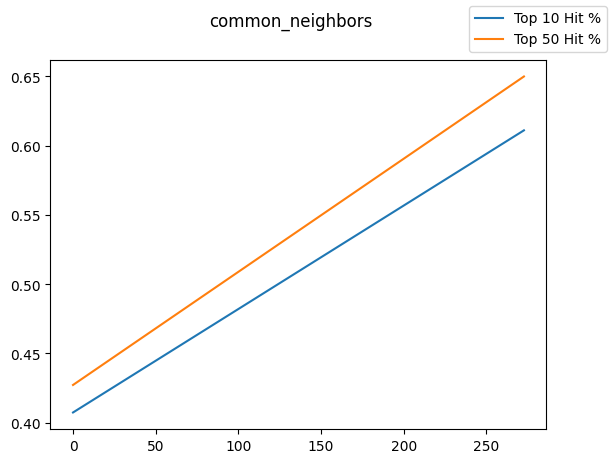

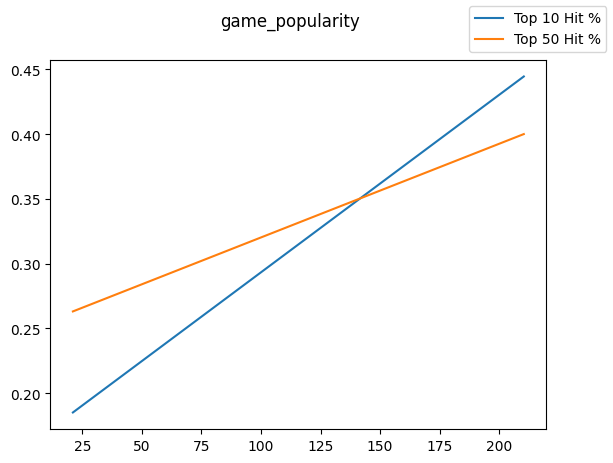

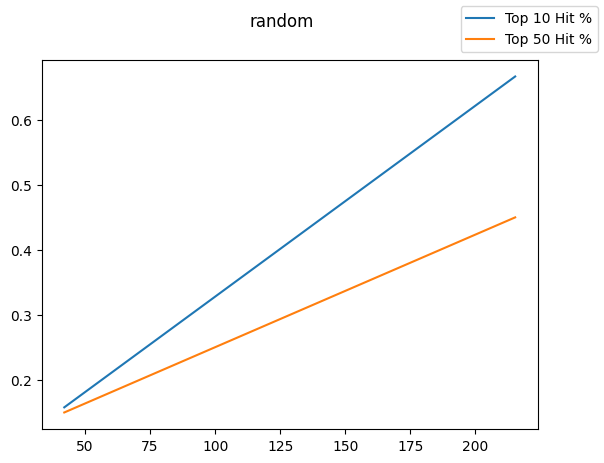

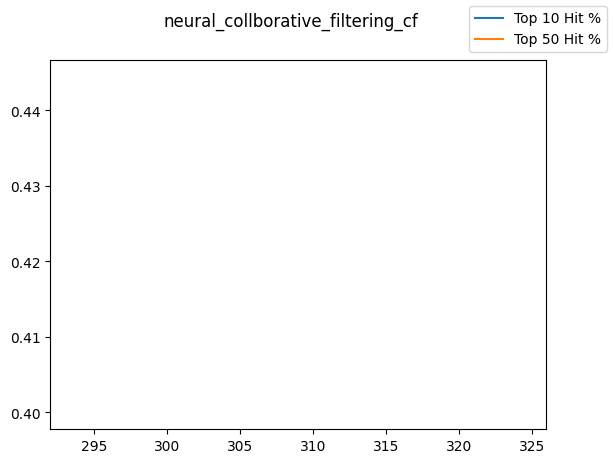

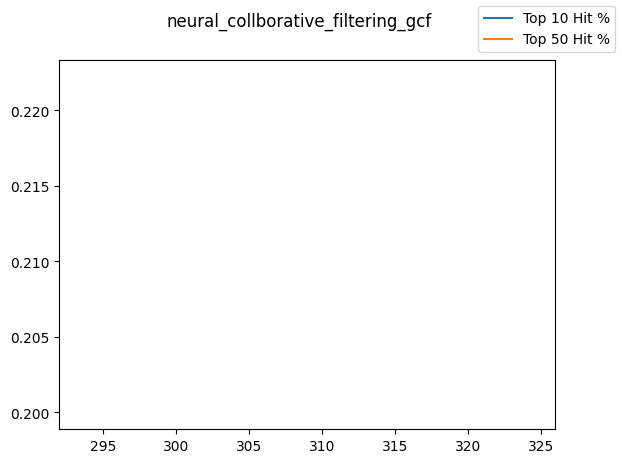

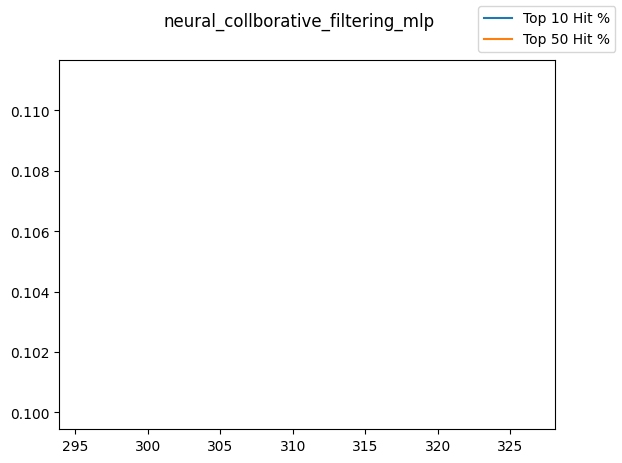

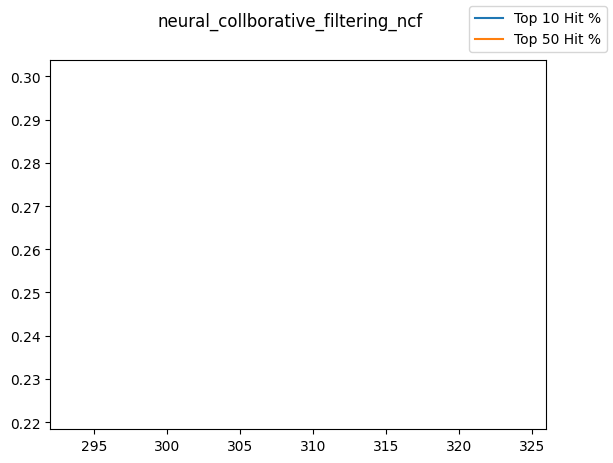

In [4]:
bucket_width = 5

cur_models_by_name = defaultdict(list)
for model_name, model_save_path in current_models:
    if model_save_path not in evaluation_names:
        continue
    cur_models_by_name[model_name].append(model_save_path)
for model_name, model_save_paths in cur_models_by_name.items():
    evaluator.reset(model_name, model_save_paths)
    num_interactions = evaluator.results_df["num_game_interactions_external"] + evaluator.results_df["num_game_interactions_local"]
    min_num = num_interactions.min()
    max_num = num_interactions.max()

    xs = []
    y_10s = []
    y_50s = []
    bucket_width = (max_num - min_num) / 3
    for start in [min_num, min_num + 2 * bucket_width]:
        evaluator.reset(model_name, model_save_paths, start, start + bucket_width)
        if evaluator.metrics["num_interactions"] == 0:
            continue
        evaluator.compute_top_N_hit_percentage(10)
        evaluator.compute_top_N_hit_percentage(50)
        xs.append(start)
        y_10s.append(evaluator.metrics["top_10_hit_percentage"])
        y_50s.append(evaluator.metrics["top_50_hit_percentage"])
    fig = plt.figure()
    fig.suptitle(model_name)
    ax = fig.add_subplot()
    ax.plot(xs, y_10s, label="Top 10 Hit %")
    ax.plot(xs, y_50s, label="Top 50 Hit %")
    fig.legend()

In [5]:
# groups = evaluator.all_results.groupby(by=["rec_model_name", "rec_model_save_path"])
# for (model_name, model_save_path), data in groups:
all_metrics = []
for model_name, model_save_path in current_models:
    evaluator.reset(model_name, model_save_path)
    # evaluator.plot_top_N_hit_percentage_percentiles(10)
    evaluator.compute_top_N_hit_percentage(10)
    # evaluator.plot_top_N_hit_percentage_percentiles(50)
    evaluator.compute_top_N_hit_percentage(50)
    # evaluator.plot_user_rank_roc_curve()
    evaluator.compute_user_rank_auc_roc()
    # evaluator.save_metrics('test_online_evaluator', overwrite=True)
    # pprint(evaluator.metrics)
    all_metrics.append({'model_name': model_name, 'model_save_path': model_save_path, **evaluator.metrics})
    # print()
results = pd.DataFrame(all_metrics)
estimate_probability_each_model_is_best(results, 'user_rank_auc_roc')
estimate_probability_each_model_is_best(results, 'top_10_hit_percentage')
estimate_probability_each_model_is_best(results, 'top_50_hit_percentage')

Not enough samples for AUC ROC neural_collborative_filtering_mlp evaluation_test_mlp_low_weight_decay_increased_lr_best_model_bugfix


/Users/jackson/Desktop/Classes/2024 Spring/ML Projects/ml-projects-project/evaluation/compare_auc_delong_xu.py:71: RuntimeWarning: Degrees of freedom <= 0 for slice
  sx = np.cov(v01)
/Users/jackson/.pyenv/versions/3.11.3/envs/ml_project_3.11.3/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/jackson/.pyenv/versions/3.11.3/envs/ml_project_3.11.3/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/jackson/Desktop/Classes/2024 Spring/ML Projects/ml-projects-project/evaluation/compare_auc_delong_xu.py:71: RuntimeWarning: Degrees of freedom <= 0 for slice
  sx = np.cov(v01)
/Users/jackson/.pyenv/versions/3.11.3/envs/ml_project_3.11.3/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/jac

In [6]:
df = results.loc[results['model_save_path'].isin(evaluation_names), ['model_save_path', 'top_50_hit_percentage_best_probability', 'top_50_hit_percentage', 'top_50_hit_percentage_variance', 'num_interactions', 'top_10_hit_percentage_best_probability', 'top_10_hit_percentage', 'top_10_hit_percentage_variance', 'user_rank_auc_roc_best_probability', 'user_rank_auc_roc', 'user_rank_auc_roc_variance']].copy()
df['model_save_path'] = df['model_save_path'].map(evaluation_names)
display(df.sort_values(by='top_50_hit_percentage_best_probability', ascending=False))

,model_save_path,top_50_hit_percentage_best_probability,top_50_hit_percentage,top_50_hit_percentage_variance,num_interactions,top_10_hit_percentage_best_probability,top_10_hit_percentage,top_10_hit_percentage_variance,user_rank_auc_roc_best_probability,user_rank_auc_roc,user_rank_auc_roc_variance
2,common_neighbors_gaussian_scoring,0.47988,0.573770,0.015677,61,0.48062,0.592593,0.019943,0.02125,0.555495,0.005668
1,common_neighbors_percentile_scoring,0.25274,0.480000,0.033265,50,0.13403,0.407407,0.037037,0.00010,0.368590,0.006364
0,common_neighbors_constant_scoring,0.17664,0.423729,0.036898,59,0.21648,0.448276,0.049808,0.01175,0.521176,0.006729
4,random_model,0.07602,0.325581,0.038160,43,0.13258,0.321429,0.078042,0.00826,0.486453,0.009075
3,popularity_model,0.00853,0.344828,0.005913,87,0.01090,0.244444,0.022222,0.00000,0.342398,0.004623
5,collborative_filter,0.00619,0.400000,0.000000,10,0.02539,0.444444,0.000000,0.04964,0.458333,0.042361
6,non_linear_collaborative_filter,0.00000,0.400000,0.000000,10,0.00000,0.444444,0.000000,0.30969,0.708333,0.034491
8,neural_collaborative_filter,0.00000,0.300000,0.000000,10,0.00000,0.222222,0.000000,0.34097,0.666667,0.111111
9,collborative_filter_with_game_embeddings,0.00000,0.100000,0.000000,10,0.00000,0.111111,0.000000,NaN,0.777778,NaN
10,non_linear_collaborative_filter_with_game_embe...,0.00000,0.200000,0.000000,10,0.00000,0.222222,0.000000,0.14801,0.562500,0.056920
